In [1]:
! git clone https://github.com/Saurabh-Bazari/ImageColourizationUsingResnet.git

Cloning into 'ImageColourizationUsingResnet'...
remote: Enumerating objects: 2047, done.
remote: Total 2047 (delta 0), reused 0 (delta 0), pack-reused 2047
Receiving objects: 100% (2047/2047), 44.37 MiB | 48.85 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [0]:
!ls

ImageColourizationUsingResnet  sample_data


In [0]:
cd ImageColourizationUsingResnet/

/content/ImageColourizationUsingResnet


In [0]:
ls

README.md  test/  train/


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image
from skimage import io, color
import cv2

In [0]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

(50000, 32, 32, 3)

In [0]:
PATH = './train/'
files = os.listdir(PATH)

In [0]:
def normalize_data(data):
    data = data / 128
    return data

In [0]:
from PIL import Image
from skimage import io, color
import cv2

def transform_image(image, size=299, output_channels=3):
    trans = transforms.Compose([
    transforms.CenterCrop(size),
    transforms.Grayscale(num_output_channels=output_channels),
    transforms.ToTensor()
])
    return trans(image)

def get_lab(image):
    trans = transforms.CenterCrop(224)
    lab = color.rgb2lab(np.array(trans(image))/255)
    L, a, b = cv2.split(lab)
    return (L, a, b)

In [0]:
inception_images = []
fusion_images = []
lab_a = []
lab_b = []
lab_l = []

for file in files[:2]:
    
    im = Image.open(PATH + file)
    print(im)
    fusion_images.append(transform_image(im, size=224, output_channels=1))
    inception_images.append(transform_image(im))
    print( inception_images )
    L, a, b = get_lab(im)
    lab_l.append(L)
    lab_a.append(a)
    lab_b.append(b)

lab_a = normalize_data(np.array(lab_a, dtype=int))  
lab_b = normalize_data(np.array(lab_b, dtype=int))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x7F05E547CE10>
torch.Size([3, 299, 299])
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=364x243 at 0x7F05E54955F8>
torch.Size([3, 299, 299])


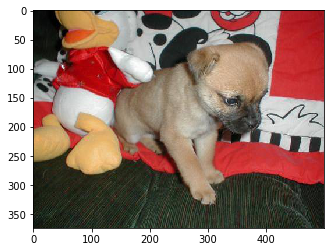

In [0]:
fusion_images = torch.stack(fusion_images)
inception_images = torch.stack(inception_images)
ab = torch.cat([torch.Tensor(lab_a).unsqueeze(1), torch.Tensor(lab_b).unsqueeze(1)], dim=1)
plt.imshow(im)

In [0]:
class imagedata(Dataset):
    
    def __init__(self):
        super().__init__()
        self.inception_images = inception_images
        self.fusion_images = fusion_images
        self.y_data = ab
        self.len = len(self.inception_images)
        
    def __getitem__(self, index):
        return self.inception_images[index], self.fusion_images[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [0]:
batch_size = 20
imageset = imagedata()
train_loader = torch.utils.data.DataLoader(imageset, batch_size=batch_size)

In [0]:
model_inception = models.inception_v3(pretrained=True).cuda()
model_inception.transform_input = False
model_inception.eval();
for param in model_inception.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:01<00:00, 54.9MB/s] 


In [0]:
def multiply_features(features):

    feature_mult = []

    for i in range(batch_size):
        print( features[i].shape )
        repeat = features[i].repeat(28 * 28)
        x = repeat.view(28, 28, 1000).transpose(1, 2).transpose(0,1)
        feature_mult.append(x)

    features_mult = torch.stack(feature_mult)
    #features_mult = features_mult.cuda()
    
    return features_mult

In [0]:
class fusion_model(nn.Module):
    
    def __init__(self):
        super(fusion_model, self).__init__()        
        
        sizes = [64, 128, 128, 256, 256, 512, 512,  256]
        s_modules = [nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),\
                                   nn.ReLU(inplace=True), nn.BatchNorm2d(64))]
        
        for i in range(len(sizes) - 1):
            s = 2 if i in [1,3] else 1
            s_modules.extend(nn.Sequential(nn.Conv2d(sizes[i], sizes[i + 1], kernel_size=3, stride=s, padding=1),\
                                           nn.ReLU(inplace=True), nn.BatchNorm2d(sizes[i + 1])))
        
        self.encoder = nn.Sequential(*s_modules)
        
        e_modules = [nn.Conv2d(1256, 256, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(256)]
        sizes = [256,128,64,64,32]
        
        for i in range(len(sizes) - 1):
            e_modules.extend(nn.Sequential(nn.Conv2d(sizes[i], sizes[i + 1], kernel_size=3, stride=1, padding=1),\
                                           nn.ReLU(inplace=True), nn.BatchNorm2d(sizes[i + 1])))
            if i in [0,2]:
                e_modules.extend(nn.Sequential(nn.Upsample(scale_factor=2)))
        
        self.decoder = nn.Sequential(*e_modules)
        
        
        self.out = nn.Sequential(nn.Conv2d(32,2,kernel_size=3,stride=1,padding=1), nn.Upsample(scale_factor=2))
        self.up = nn.Upsample(scale_factor=2)
        
    
    def forward(self, x, x_incept):
        x = self.encoder(x)
        incept = model_inception(x_incept)
        x = torch.cat([x, multiply_features(incept)], dim=1)
        x = self.decoder(x)
        x = self.up(F.tanh(self.out(x)))

        return x

In [0]:
model=fusion_model()
model.cuda();
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [0]:
LossList = []

In [0]:
def train(epochs):
    count = 0
    for epoch in range(epochs):
        loss1 = 0.0
        for i, (inception_images, fusion_images, target) in enumerate(train_loader):

            target = target.cuda()
            
            inception_images = torch.autograd.Variable(inception_images).cuda()
            fusion_images = torch.autograd.Variable(fusion_images).cuda()
           
            result = model(fusion_images, inception_images)
            loss = criterion(result, target)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            loss1 += (loss.data.item())
            print("Epoch : " , epoch + 1 ,'   batch : ' ,i , "   Loss : ", loss.data.item())
        loss1 = loss1/100
        LossList.append(loss1)

In [0]:
train(20)

NameError: ignored

In [0]:
print(LossList)

[0.013457227242179215, 0.00900777727831155, 0.008064058828167617, 0.007628427939489484, 0.0073665916966274385, 0.007184611961711198, 0.007045973788481205, 0.006933911326341331, 0.006839471878483891, 0.0067575555038638414, 0.006684968064073473, 0.006619499961379916, 0.006559521788731217, 0.006503897805232555, 0.0064517258177511395, 0.00640227974159643, 0.006354988613165915, 0.00630948567064479, 0.0062653771438635885, 0.006222425419837236]


In [0]:
def create_images(colours, ix):
    lab_images = []
    pos = ix * colours.size(0)
    for i in range(colours.size(0)):
        a = np.array(colours[i][0].cpu()) * 128
        b = np.array(colours[i][1].cpu()) * 128
        lab = np.zeros([224, 224, 3])
        lab[:, :, 0] = lab_l[i + pos]
        lab[:, :, 1] = a
        lab[:, :, 2] = b
        lab_images.append(lab)
    
    return lab_images

In [0]:
PATH = './test/'

In [0]:
files = os.listdir(PATH)

In [0]:
inception_images = []
fusion_images = []
lab_a = []
lab_b = []
lab_l = []

for file in files[:20]:
    
    im = Image.open(PATH + file)
    fusion_images.append(transform_image(im, size=224, output_channels=1))
    inception_images.append(transform_image(im))
    L, a, b = get_lab(im)
    lab_l.append(L)
    lab_a.append(a)
    lab_b.append(b)

lab_a = normalize_data(np.array(lab_a, dtype=int))  
lab_b = normalize_data(np.array(lab_b, dtype=int))

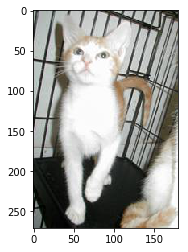

In [0]:
fusion_images = torch.stack(fusion_images)
inception_images = torch.stack(inception_images)
ab = torch.cat([torch.Tensor(lab_a).unsqueeze(1), torch.Tensor(lab_b).unsqueeze(1)], dim=1)
plt.imshow(im)
imageset = imagedata()
test_loader = torch.utils.data.DataLoader(imageset, batch_size=batch_size)
test_loss = []

In [0]:
for i, (inception_images, fusion_images, target) in enumerate(test_loader):
    print(i)
    inception_images = torch.autograd.Variable(inception_images).cuda()
    fusion_images = torch.autograd.Variable(fusion_images).cuda()
    result = model(fusion_images, inception_images)
    loss = criterion(result, target.cuda())
#     optimizer.zero_grad()
#     loss.backward()
#     print(loss.data.item())
    print(loss)
    ims1 = fusion_images
    ims = create_images(result.data, i)
    if i == 0:
        break

0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward>)


In [0]:
for i in range(len(ims)):
    print(i+1," Image")
    ims111 = np.array(ims1[i][0].cpu())
    plt.imshow(ims111,cmap='gray')
    plt.show()
    plt.imshow(color.lab2rgb(ims[i]))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

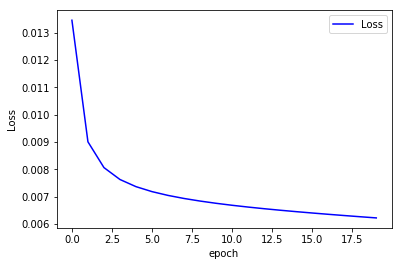

In [0]:
plt.plot(LossList, c='b', label="Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()